In [4]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset
from torch.utils.data.sampler import SubsetRandomSampler
import matplotlib
import matplotlib.pyplot as plt
from PIL import Image
from torchvision import datasets, transforms, models
from torch.autograd import Variable
from zipfile import ZipFile
import os
from os import path
import shutil

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
url = '/content/drive/MyDrive/SoftCom_Lab/Assignment_2/'

In [7]:
dataset_A = url + 'dataset_2_image.zip'
with ZipFile(dataset_A, 'r') as zip:
  zip.extractall()

In [8]:
PATH = '/content/'
train_data_labels = pd.read_csv('/content/csv/updatetrain.csv', usecols = ['filename', 'digit'])
test_data_labels = pd.read_csv('/content/csv/updatetest.csv', usecols = ['filename', 'digit'])
train_data_labels.head()


,filename,digit
0,0.jpg,9
1,1.jpg,0
2,2.jpg,0
3,3.jpg,3
4,4.jpg,0


In [9]:
class Dataset(Dataset):
    def __init__(self, df, root, transform=None):
        self.data = df
        self.root = root
        self.transform = transform
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, index):
        item = self.data.iloc[index]
        
        path = self.root + "/" + item[0]
        image = Image.open(path).convert('L')
        label = item[1]
        
        if self.transform is not None:
            image = self.transform(image)
            
        return image, label

In [10]:
mean = [0.5,]
std = [0.5, ]

train_transform = transforms.Compose([
    transforms.Resize(28),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

test_transform = transforms.Compose([
        transforms.Resize(28),
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
])

train_data  = Dataset(train_data_labels, '/content/train', train_transform)
test_data = Dataset(test_data_labels, '/content/test_28', test_transform)

print("Trainig Samples: ", len(train_data))

Trainig Samples:  60000


# **Base Parameters**

In [11]:
batch_size = 100
num_iters = 40000
input_dim = 28*28
num_hidden = 800
output_dim = 10

learning_rate = 0.05

num_epochs = num_iters / (len(train_data) / batch_size)
num_epochs = int(num_epochs)
print(num_epochs)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

66


In [12]:
test_size = 0.2
num_train = len(train_data)
indices = list(range(num_train))
np.random.shuffle(indices)
split = int(np.floor(test_size * num_train))
train_idx, test_idx = indices[split:], indices[:split]

train_sampler = SubsetRandomSampler(train_idx)
test_sampler = SubsetRandomSampler(test_idx)

train_loader = torch.utils.data.DataLoader(
    train_data, batch_size=batch_size,
    sampler=train_sampler)

test_loader = torch.utils.data.DataLoader(
    train_data, batch_size=batch_size,
    sampler=test_sampler)

print("Train dataloader:{}".format(len(train_loader)))
print("Test dataloader:{}".format(len(test_loader)))

Train dataloader:480
Test dataloader:120


In [13]:
class DeepNeuralNetworkModel(nn.Module):
    def __init__(self, input_size, num_classes, num_hidden):
        super().__init__()
       
        self.linear_1 = nn.Linear(input_size, num_hidden)
        self.relu_1 = nn.ReLU()
 
        self.linear_2 = nn.Linear(num_hidden, num_hidden)
        self.relu_2 = nn.ReLU()
 
        self.linear_3 = nn.Linear(num_hidden, num_hidden)
        self.relu_3 = nn.ReLU()
 
        self.linear_4 = nn.Linear(num_hidden, num_hidden)
        self.relu_4 = nn.ReLU()
 
        self.linear_5= nn.Linear(num_hidden, num_hidden)
        self.relu_5= nn.ReLU()
 
        self.linear_6 = nn.Linear(num_hidden, num_hidden)
        self.relu_6 = nn.ReLU()
 
        self.linear_out = nn.Linear(num_hidden, num_classes)
 
    def forward(self, x):
        out  = self.linear_1(x)
        out = self.relu_1(out)
        
        out  = self.linear_2(out)
        out = self.relu_2(out)
 
        out  = self.linear_3(out)
        out = self.relu_3(out)
 
        out  = self.linear_4(out)
        out = self.relu_4(out)
 
        out  = self.linear_5(out)
        out = self.relu_5(out)
 
        out  = self.linear_6(out)
        out = self.relu_6(out)
        
        probas  = self.linear_out(out)
        return probas

In [14]:
model = DeepNeuralNetworkModel(input_size = input_dim, num_classes = output_dim, num_hidden = num_hidden)

model.to(device)

DeepNeuralNetworkModel(
  (linear_1): Linear(in_features=784, out_features=800, bias=True)
  (relu_1): ReLU()
  (linear_2): Linear(in_features=800, out_features=800, bias=True)
  (relu_2): ReLU()
  (linear_3): Linear(in_features=800, out_features=800, bias=True)
  (relu_3): ReLU()
  (linear_4): Linear(in_features=800, out_features=800, bias=True)
  (relu_4): ReLU()
  (linear_5): Linear(in_features=800, out_features=800, bias=True)
  (relu_5): ReLU()
  (linear_6): Linear(in_features=800, out_features=800, bias=True)
  (relu_6): ReLU()
  (linear_out): Linear(in_features=800, out_features=10, bias=True)
)

In [15]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr = learning_rate)

In [16]:
iteration_loss = []
iter = 0
for epoch in range(num_epochs):
    print('Epoch: ', epoch + 1)
    for i, (images, labels) in enumerate(train_loader):

        images = images.view(-1, 28*28).to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        outputs = model(images) 

        loss = criterion(outputs, labels)

        loss.backward()

        optimizer.step()

        iter += 1

        if iter % 500 == 0:        
            correct = 0
            total = 0
            for images, labels in test_loader:
               
                images = images.view(-1, 28*28).to(device)

                outputs = model(images)

                _, predicted = torch.max(outputs, 1)

                total += labels.size(0)

                if torch.cuda.is_available():
                    correct += (predicted.cpu() == labels.cpu()).sum() 
                else:
                    correct += (predicted == labels).sum()

            accuracy = 100 * correct.item() / total

            iteration_loss.append(loss.item())
            print('Iteration: {}. Loss: {}. Accuracy: {}'.format(iter, loss.item(), accuracy))

Epoch:  1
Epoch:  2
Iteration: 500. Loss: 1.0022555589675903. Accuracy: 63.25
Epoch:  3
Iteration: 1000. Loss: 0.6914819478988647. Accuracy: 76.10833333333333
Epoch:  4
Iteration: 1500. Loss: 0.4341988265514374. Accuracy: 83.525
Epoch:  5
Iteration: 2000. Loss: 0.37366604804992676. Accuracy: 84.43333333333334
Epoch:  6
Iteration: 2500. Loss: 0.3063802421092987. Accuracy: 85.43333333333334
Epoch:  7
Iteration: 3000. Loss: 0.3643293082714081. Accuracy: 86.95833333333333
Epoch:  8
Iteration: 3500. Loss: 0.3527523875236511. Accuracy: 87.15
Epoch:  9
Iteration: 4000. Loss: 0.3079942464828491. Accuracy: 88.0
Epoch:  10
Iteration: 4500. Loss: 0.3624494969844818. Accuracy: 87.76666666666667
Epoch:  11
Iteration: 5000. Loss: 0.2578515112400055. Accuracy: 88.425
Epoch:  12
Iteration: 5500. Loss: 0.42319294810295105. Accuracy: 86.175
Epoch:  13
Iteration: 6000. Loss: 0.3948904275894165. Accuracy: 88.35
Epoch:  14
Iteration: 6500. Loss: 0.19323574006557465. Accuracy: 87.46666666666667
Epoch:  15
I

In [18]:
torch.save(model.state_dict(), '/content/drive/MyDrive/SoftCom_Lab/Assignment_2/Dataset2_Models/exp3/model_base3.pkl')

[1.0022555589675903, 0.6914819478988647, 0.4341988265514374, 0.37366604804992676, 0.3063802421092987, 0.3643293082714081, 0.3527523875236511, 0.3079942464828491, 0.3624494969844818, 0.2578515112400055, 0.42319294810295105, 0.3948904275894165, 0.19323574006557465, 0.2710966169834137, 0.21038320660591125, 0.0650733932852745, 0.21758192777633667, 0.2692345380783081, 0.19961903989315033, 0.11895038932561874, 0.17527619004249573, 0.1988593339920044, 0.05682654306292534, 0.17569857835769653, 0.1344415545463562, 0.14267441630363464, 0.14604552090168, 0.19365108013153076, 0.1705481857061386, 0.14242221415042877, 0.1457395702600479, 0.0745985209941864, 0.06227428838610649, 0.07094153761863708, 0.03332262113690376, 0.051469359546899796, 0.12167654931545258, 0.17042453587055206, 0.13082516193389893, 0.0722416341304779, 0.10278487205505371, 0.0751722976565361, 0.06771272420883179, 0.047370146960020065, 0.05702926591038704, 0.052466344088315964, 0.014866112731397152, 0.11799753457307816, 0.04078921

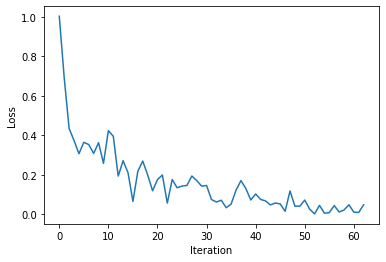

In [19]:
print (iteration_loss)
plt.plot(iteration_loss)
plt.ylabel('Loss')
plt.xlabel('Iteration')
plt.show()